This notebook makes some of the figures that were in my burrito analysis [presentation at Cognition at the Shore, 2018] (URL TBD).

# Imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import util
import os
import string
from IPython.display import HTML

pd.options.display.max_columns=25
sns.set_style('whitegrid')

/Users/scott/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
if not os.path.exists('/gh/fig/cogshore/'):
    os.mkdir('/gh/fig/cogshore/')

# 1. Load data

In [3]:
df, df_shops, df_ingredients = util.load_burritos()
df['Value'] = df['Volume'] / df['Cost']
df.tail()

,Location,Burrito,Date,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Value
368,tony's fresh mexican food,la paz,5/22/2018,9.99,5.0,NaN,NaN,20.0,22.0,0.77,4.0,4.0,3.0,3.0,5.0,3.5,NaN,3.0,4.5,4.0,NaN,hannah,NaN,0.077077
369,tony's fresh mexican food,la paz,5/22/2018,9.99,4.0,NaN,NaN,20.0,22.0,0.77,5.0,5.0,3.0,3.0,4.0,4.0,2.0,4.0,3.0,4.0,NaN,mike,NaN,0.077077
370,tony's fresh mexican food,adobada,5/22/2018,7.39,4.0,NaN,NaN,24.0,21.0,0.84,5.0,4.0,4.0,3.0,4.0,5.0,4.0,4.0,5.0,4.0,NaN,nick g.,NaN,0.113667
371,tony's fresh mexican food,adobada,5/22/2018,7.39,4.5,NaN,NaN,21.0,22.5,0.85,3.5,4.5,4.0,3.5,2.0,1.0,3.5,3.5,4.0,3.5,NaN,ricardo,NaN,0.115020
372,tony's fresh mexican food,veggie,5/22/2018,7.39,4.0,NaN,NaN,22.0,20.0,0.70,3.0,5.0,NaN,3.0,NaN,4.0,NaN,3.0,4.0,3.5,NaN,erin,NaN,0.094723


### Metadata

In [4]:
print('Number of burritos:', len(df))
print('Number of restaurants:', df.Location.nunique())
print('Number of reviewers:', df.Reviewer.nunique())
print('Total cost: ${:.2f}'.format(df.Cost.sum()))
print('Total volume: {:.0f} L'.format(np.mean(df['Volume'])*len(df)))
print('% burritos Scott: {:.0f}%'.format(100*np.mean(df['Reviewer'].str.contains('scott'))))
print('% burritos California: {:.0f}%'.format(100*np.mean(df['Burrito'].str.contains('cali'))))

Number of burritos: 373
Number of restaurants: 79
Number of reviewers: 71
Total cost: $2582.61
Total volume: 293 L
% burritos Scott: 38%
% burritos California: 46%


### Top reviewers

In [5]:
df.Reviewer.value_counts()[:10]

scott      141
emily       58
ricardo     18
sage        14
richard     10
luis        10
elynn       10
brent        8
erin         7
tom          7
Name: Reviewer, dtype: int64

# 2. Word cloud

(-0.5, 809.5, 749.5, -0.5)

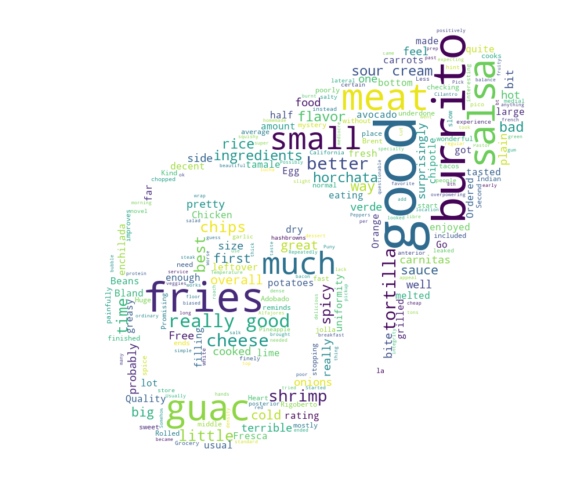

In [6]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# Get text of notes
text = ' '.join(df['Notes'].dropna().values)

# read the mask image. Mask from Creative Stall on Noun Project
burrito_mask = np.array(Image.open('/gh/fig/burritoposter/burritomask.png'))

# generate word cloud without stopwords
stopwords = set(STOPWORDS)
stopwords.add("said")
wc = WordCloud(background_color="white", max_words=2000, mask=burrito_mask,
               stopwords=stopwords)
wc.generate(text)

# store to file
wc.to_file('/gh/fig/cogshore/wordcloud.png')

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

# 4. Ranking of taco shops by overall rating

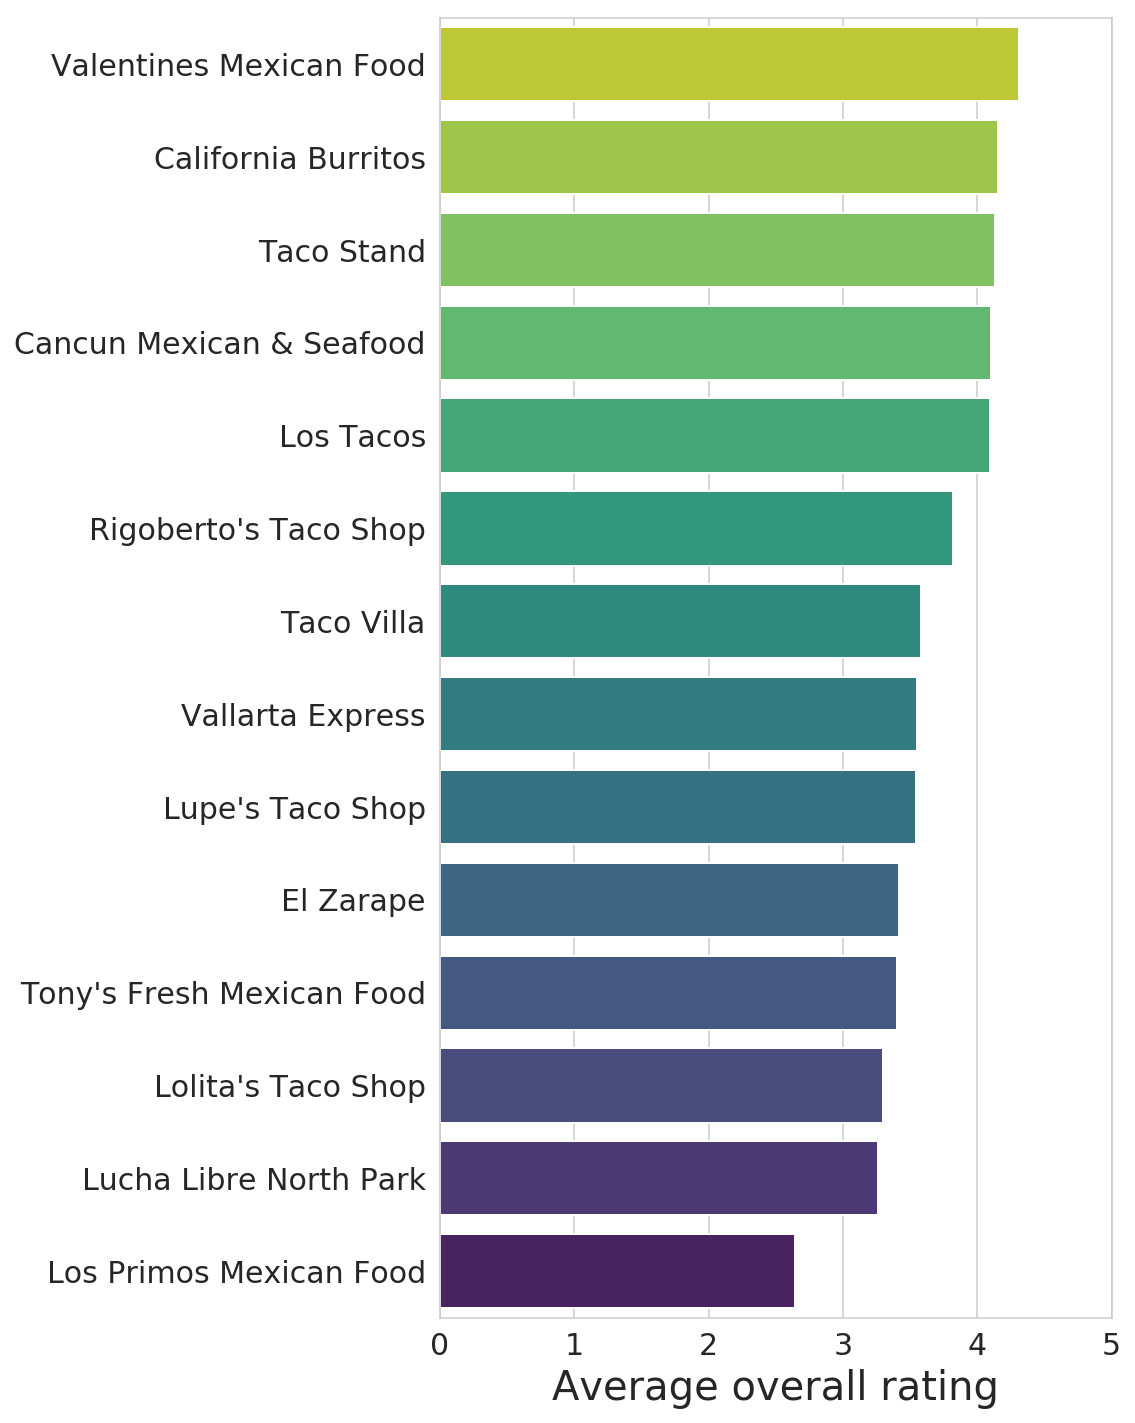

In [7]:
# Limit analysis to Locations with at least N burritos
minN = 5
shops_counts = df['Location'].value_counts()
shops_keep = shops_counts[shops_counts>minN].index
df_best = df[df.Location.isin(shops_keep)]
overall_ranks = df_best.groupby('Location').mean()['overall'].sort_values(ascending=False)
df_overall = overall_ranks.reset_index()
df_plt = df_overall.copy()
df_plt['Location'] = [string.capwords(loc) for loc in df_plt['Location']]

plt.figure(figsize=(8,10))
sns.barplot(y='Location', x='overall', data=df_plt, palette='viridis_r')
plt.xlim((0,5))
plt.yticks(size=15)
plt.xticks(np.arange(6), size=15)
plt.xlabel('Average overall rating', size=20)
plt.ylabel('')

plt.tight_layout()
plt.savefig('/gh/fig/cogshore/overall_rank.png')

# 5. Best taco shops for each burrito dimension

In [8]:
# Determine average rating for each feature for each taco shop
df_ratings = df[['Location','overall','Tortilla','Temp','Meat','Fillings',
                 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy','Wrap']]
mean_ratings_by_shop = df_ratings.groupby('Location').mean()

# Limit to taco shops with a minimum number of ratings
min_ratings = 5
mean_ratings_by_shop['N'] = df['Location'].value_counts()
mean_ratings_by_shop = mean_ratings_by_shop[mean_ratings_by_shop['N'] >= min_ratings]
mean_ratings_by_shop.drop('N', axis=1, inplace=True)

# Determine taco shops with highest average rating
df_temp = mean_ratings_by_shop.T.stack().reset_index()
idx_temp = df_temp.groupby('level_0')[0].transform(max) == df_temp[0]
df_print = df_temp[idx_temp].rename(columns={'level_0': 'Feature', 0: 'Avg Rating'}).set_index('Feature')

# Table formatting
df_print['Location'] = [string.capwords(loc) for loc in df_print['Location']]
df_print = df_print.round(1)
df_print.style.set_properties(**{'font-size':'20pt'})

styles = [
    dict(selector="th", props=[("font-size", "150%"),
                               ("text-align", "center")]),
    dict(selector="td", props=[("font-size", "150%"),
                               ("text-align", "left")])
]
html = (df_print.style.set_table_styles(styles))
html

,Location,Avg Rating
Feature,,
overall,Valentines Mexican Food,4.3
Tortilla,Valentines Mexican Food,4.1
Temp,Cancun Mexican & Seafood,4.5
Meat,Taco Stand,4.3
Fillings,Valentines Mexican Food,4.1
Meat:filling,Valentines Mexican Food,4.4
Uniformity,Valentines Mexican Food,4
Salsa,Lucha Libre North Park,3.9
Synergy,Taco Stand,4.2


# 6. Correlation matrix

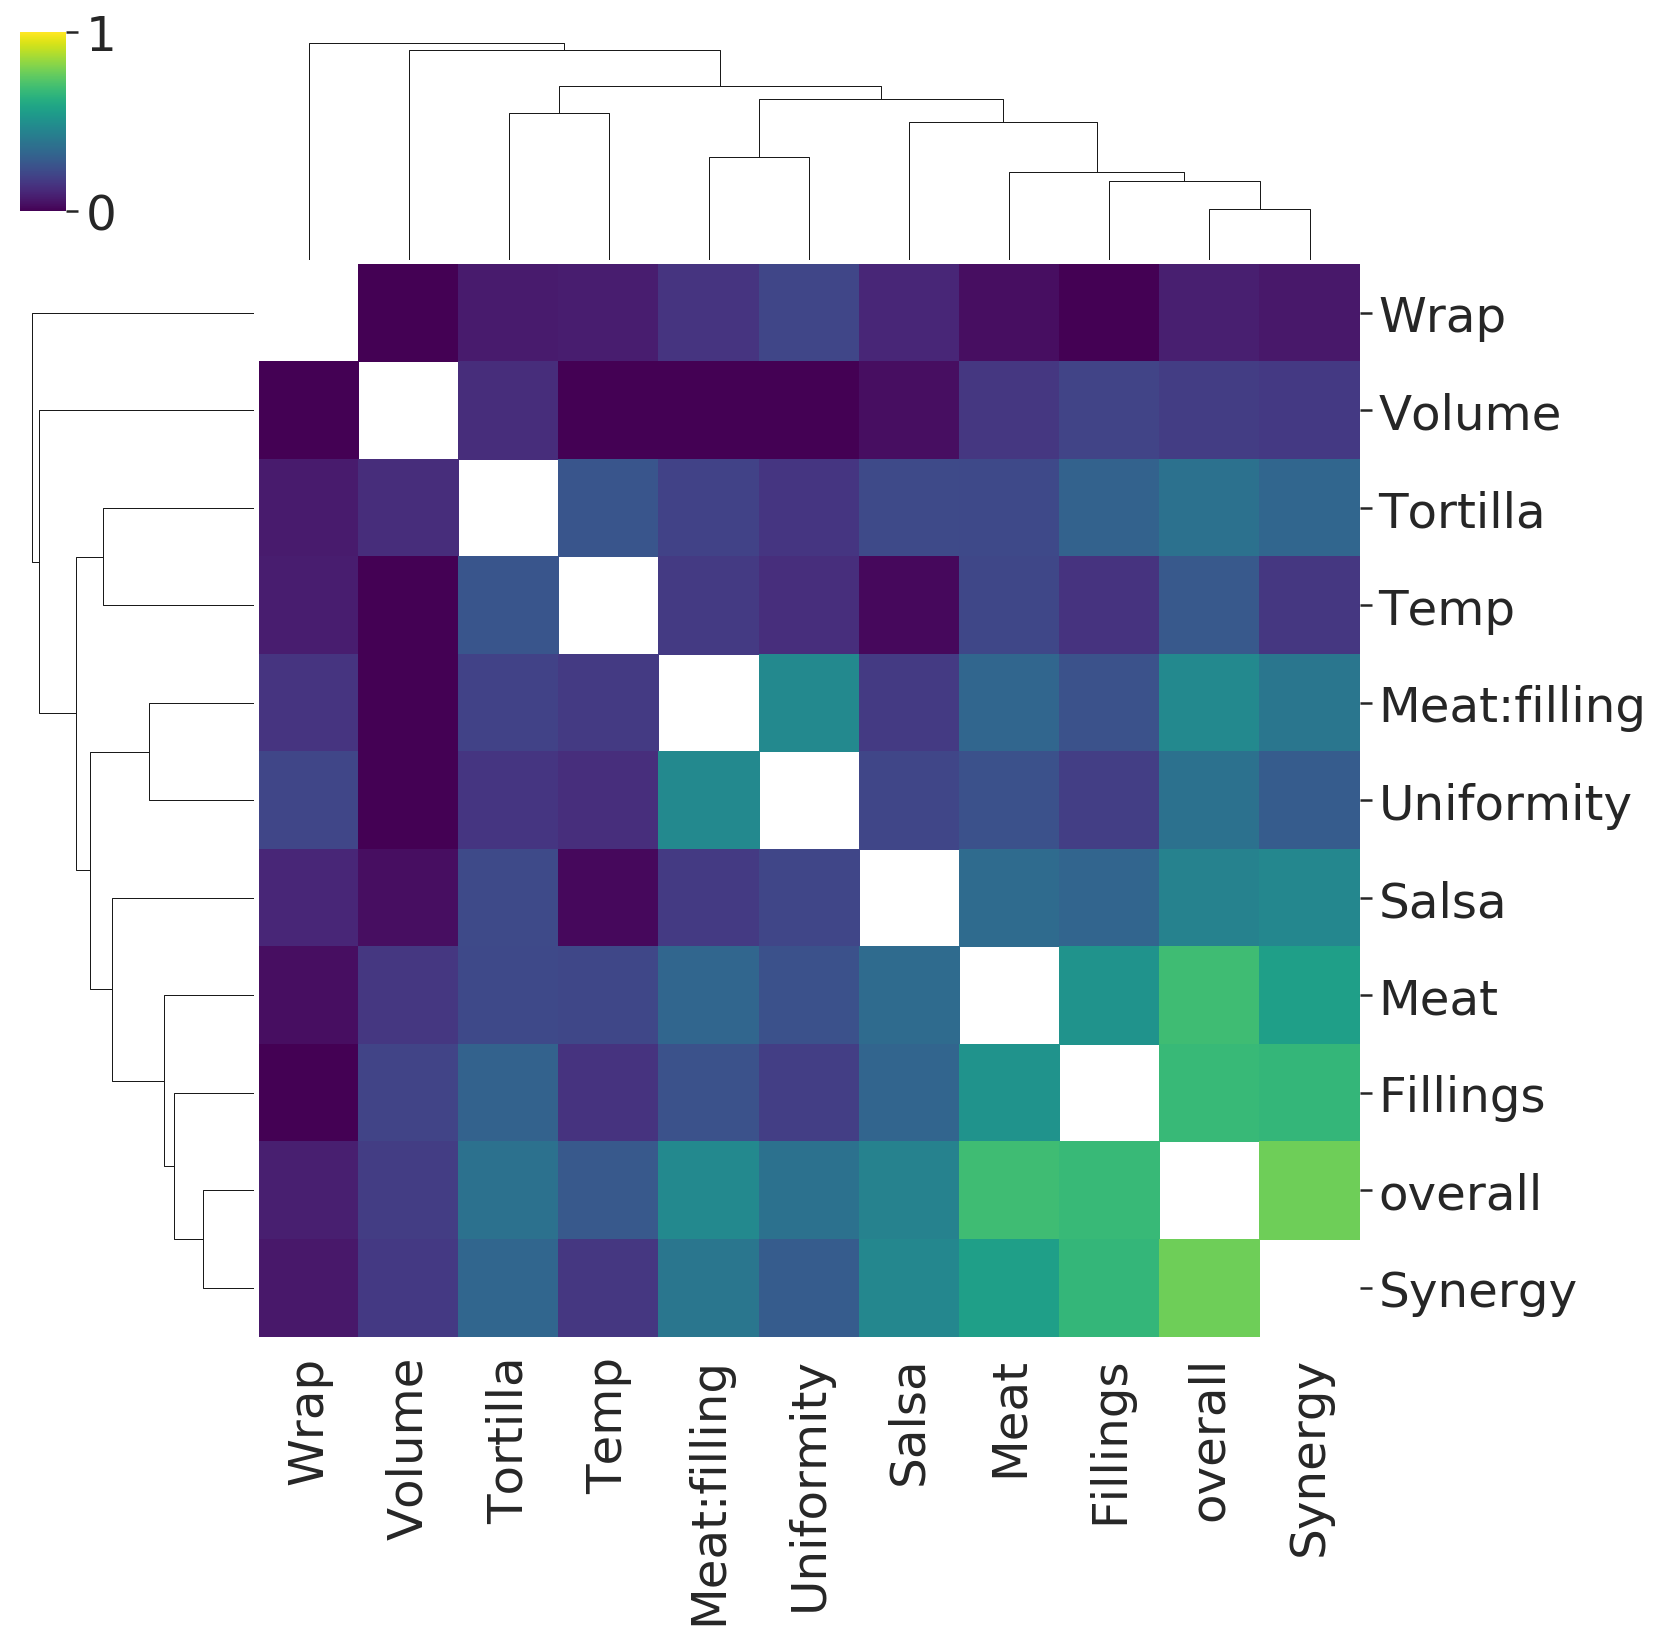

In [9]:
feat_corr = ['overall','Volume','Tortilla','Temp','Meat','Fillings',
             'Meat:filling', 'Uniformity', 'Salsa', 'Synergy','Wrap']
df_plt = df[feat_corr]
df_corrplt = df_plt.corr(method='spearman')

df_temp = df_corrplt.copy()
for feat1 in df_corrplt.columns:
    for feat2 in df_corrplt.columns:
        if feat1 == feat2:
            df_temp.loc[feat1,feat2] = True
        else:
            df_temp.loc[feat1,feat2] = False

sns.set(font_scale=2.2)
sns.set_style('whitegrid')
g = sns.clustermap(df_corrplt, vmin=0, vmax=1, cmap='viridis', mask=df_temp,
                   figsize=(12,12), cbar_kws={'ticks':[0,1]})
plt.savefig('/gh/fig/cogshore/corrmat.png', bbox_inches = "tight")

# 7. General linear model to predict overall rating from burrito features

In [10]:
# Define predictors of the model
m_lm = ['Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Wrap','Cost']
cols_keep = np.hstack((m_lm,'overall'))

# not Scott GLM
df_scott = df[df['Reviewer']=='scott']
df_scott_glm = df_scott[cols_keep].dropna()
X = sm.add_constant(df_scott_glm[m_lm])
y = df_scott_glm['overall']
my_glm = sm.GLM(y,X)
res_scott = my_glm.fit()

# Scott GLM
df_notscott = df[df['Reviewer']!='scott']
df_notscott_glm = df_notscott[cols_keep].dropna()
X = sm.add_constant(df_notscott_glm[m_lm])
y = df_notscott_glm['overall']
my_glm = sm.GLM(y,X)
res_notscott = my_glm.fit()

# All ratings
df_glm = df[cols_keep].dropna()
X = sm.add_constant(df_glm[m_lm])
y = df_glm['overall']
my_glm = sm.GLM(y,X)
res_all = my_glm.fit()
print(res_all.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:                overall   No. Observations:                   329
Model:                            GLM   Df Residuals:                       319
Model Family:                Gaussian   Df Model:                             9
Link Function:               identity   Scale:              0.14514540069091242
Method:                          IRLS   Log-Likelihood:                 -144.27
Date:                Tue, 27 Nov 2018   Deviance:                        46.301
Time:                        14:21:11   Pearson chi2:                      46.3
No. Iterations:                     2                                          
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.3672      0.215     -1.707      0.088      -0.789       0.055
Tortilla         0.0713      0.030   

### Weights trained on all reviews

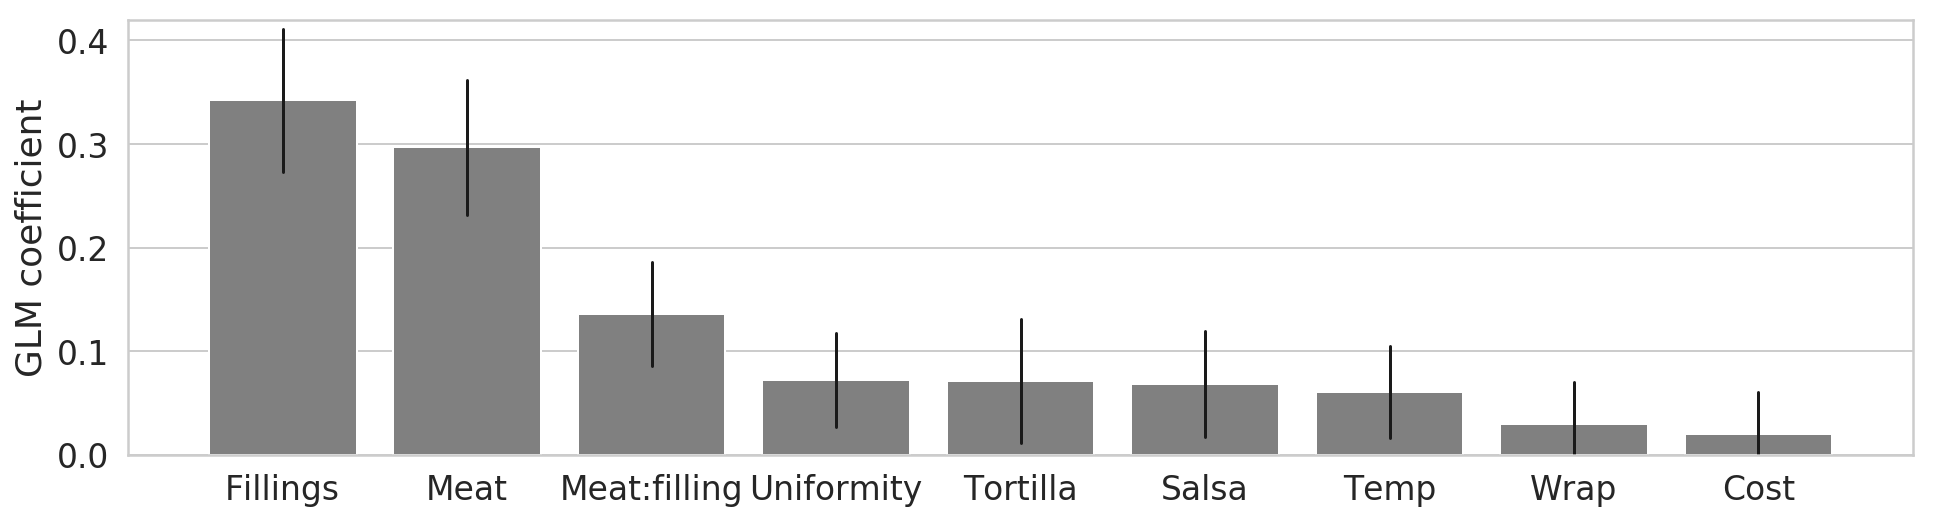

In [11]:
df_paramspre = pd.DataFrame({'Scott':res_scott.params,
                             'not Scott': res_notscott.params,
                             'all': res_all.params}).drop('const')
df_params = df_paramspre.stack().reset_index().rename(columns={
    'level_0':'feature', 'level_1':'is_scott', 0:'GLM coefficient'})

df_plt = df_params[df_params['is_scott'] == 'all']
plt.figure(figsize=(16,4))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.barplot(x='feature', y='GLM coefficient', data=df_plt, color='.5',
            order=df_paramspre['all'].sort_values(ascending=False).index)

# Make errorbars
df_conf_int = res_all.conf_int()
for i, feat in enumerate(df_paramspre['all'].sort_values(ascending=False).index):
    conf_int = (df_conf_int.loc[feat][0], df_conf_int.loc[feat][1])
    plt.plot([i,i], conf_int, 'k-')
plt.ylim(0, .42)
plt.xlabel('')
plt.savefig('/gh/fig/cogshore/GLM coefs.png', bbox_inches = "tight")


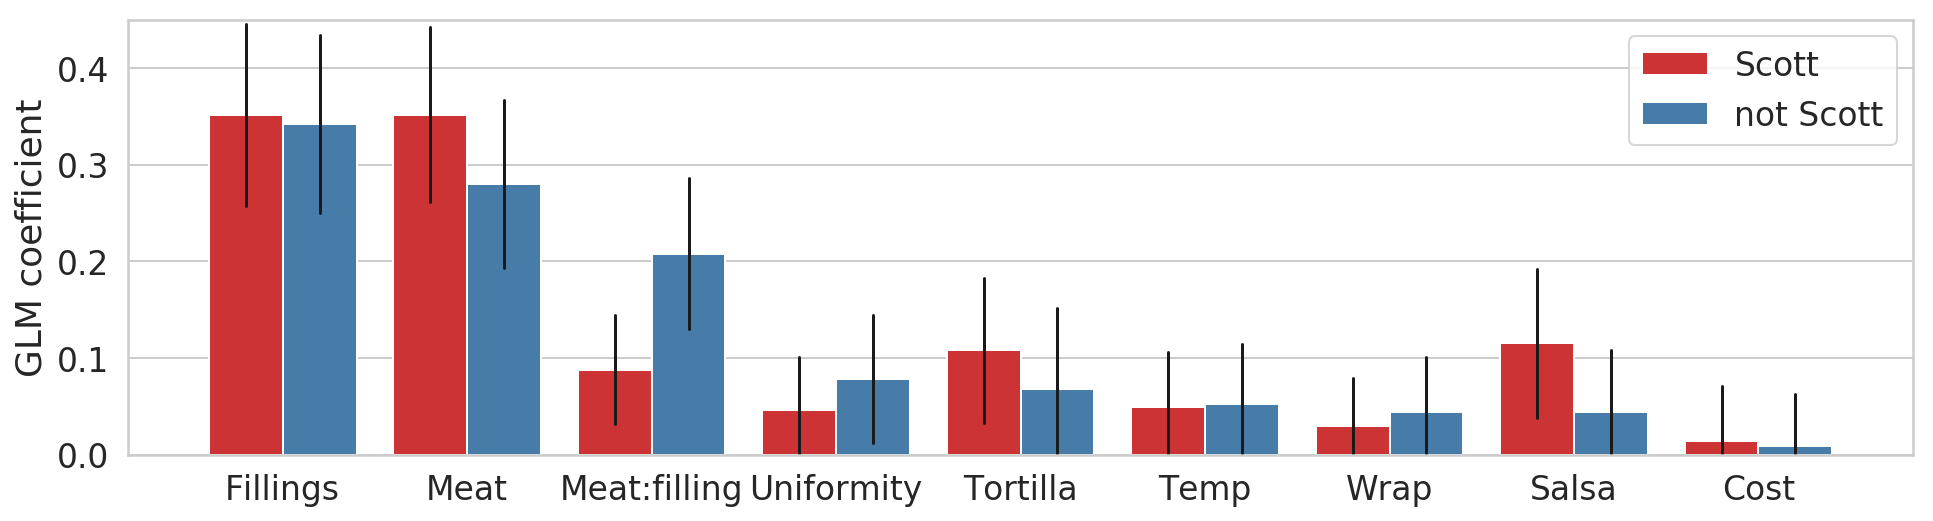

In [12]:
df_paramspre = pd.DataFrame({'Scott':res_scott.params,
                             'not Scott': res_notscott.params}).drop('const')
df_plt = df_paramspre.stack().reset_index().rename(columns={
    'level_0':'feature', 'level_1':'is_scott', 0:'GLM coefficient'})

plt.figure(figsize=(16,4))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.barplot(x='feature', y='GLM coefficient', data=df_plt, hue = 'is_scott', palette='Set1',
            order=df_paramspre['not Scott'].sort_values(ascending=False).index)

# Make errorbars
for j, is_scott in enumerate(['Scott', 'not Scott']):
    if is_scott == 'Scott':
        df_conf_int = res_scott.conf_int()
        bias = -.2
    else:
        df_conf_int = res_notscott.conf_int()
        bias = .2

    for i, feat in enumerate(df_paramspre['not Scott'].sort_values(ascending=False).index):
        conf_int = (df_conf_int.loc[feat][0], df_conf_int.loc[feat][1])
        plt.plot([i+bias,i+bias], conf_int, 'k-')
plt.ylim(0, .45)
plt.xlabel('')
plt.legend(title='')
plt.savefig('/gh/fig/cogshore/GLM coefs.png', bbox_inches = "tight")

# 8. Within and across taco shop variance

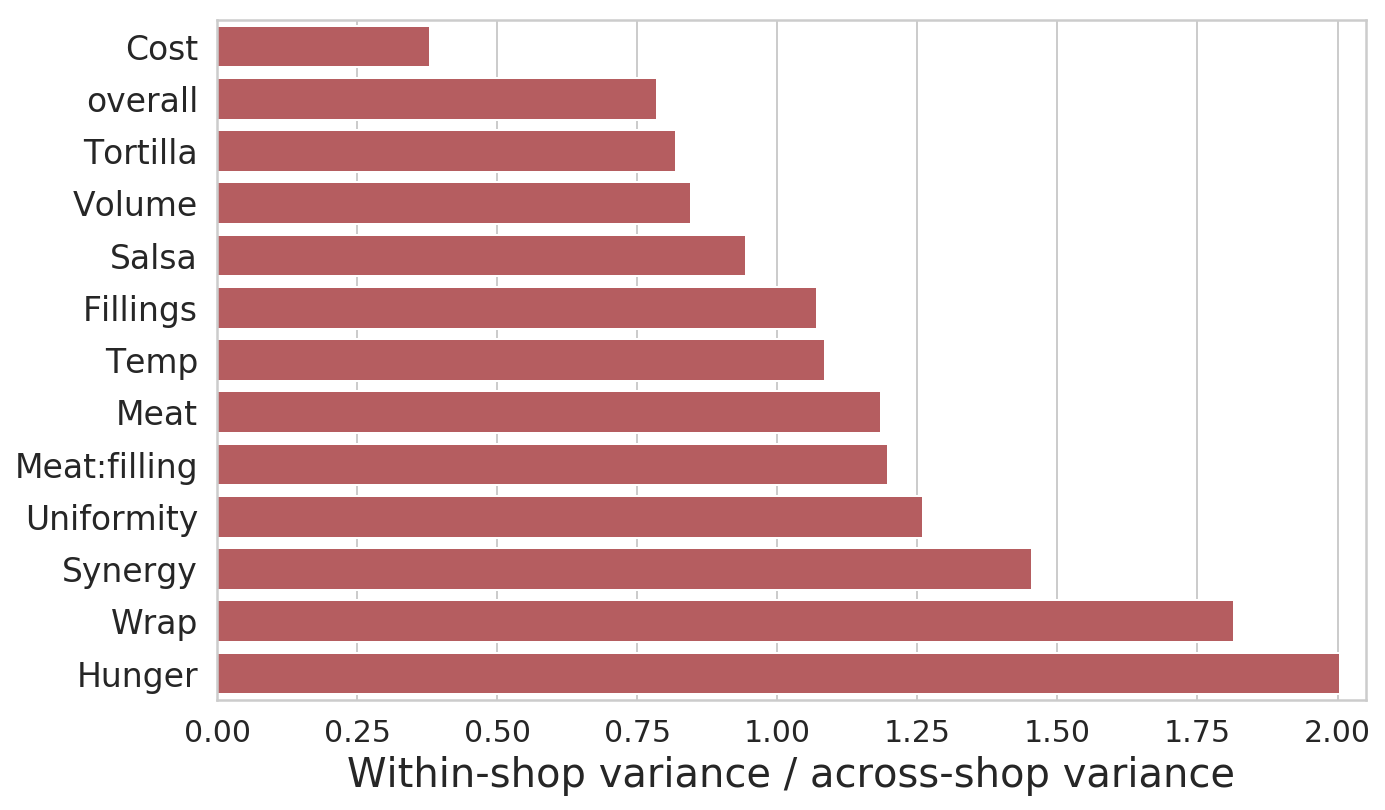

In [13]:
feats = ['Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity',
         'Salsa','Wrap', 'Synergy', 'overall', 'Hunger', 'Volume', 'Cost']

# Compute variance within restaurants
var_within_rest = df.groupby('Location')[feats].var().mean()
var_across_rest = df.groupby('Location')[feats].mean().var()
var_within_by_across = var_within_rest / var_across_rest

df_var = pd.DataFrame({'within shop': var_within_rest,
                       'across shop': var_across_rest, 
                       'within : across': var_within_by_across})
df_var = df_var.stack().reset_index().rename(columns={'level_0':'Feature', 'level_1': 'type', 0: 'Variance'})

df_plt = df_var[df_var['type'] == 'within : across']
plt.figure(figsize=(10,6))
sns.barplot(y='Feature', x='Variance', data=df_plt, color='r',
            hue_order=var_within_by_across.sort_values().index,
            order = df_plt.sort_values('Variance')['Feature'].values)
plt.ylabel('')
plt.xlabel('Within-shop variance / across-shop variance', size=20)
plt.xticks(size=15)
# plt.yticks(np.arange(0, 2.5, .5), size=15)
plt.xlim((0,2.05))
plt.tight_layout()
plt.savefig('/gh/fig/cogshore/variance_within_across.png')

### Average costs

In [14]:
Ns = df['Location'].value_counts()
df_many = df[df['Location'].isin(Ns[Ns>5].index)]
avgcosts = df_many.groupby('Location')['Cost'].mean()
avgcosts.sort_values()

Location
taco villa                   6.146800
california burritos          6.312963
cancun mexican & seafood     6.733333
el zarape                    6.750000
rigoberto's taco shop        6.820455
los primos mexican food      7.077273
lolita's taco shop           7.226923
vallarta express             7.276923
taco stand                   7.573043
lucha libre north park       7.587500
valentines mexican food      7.612500
tony's fresh mexican food    7.621111
los tacos                    8.084615
lupe's taco shop             8.360000
Name: Cost, dtype: float64

# 10. Principal component analysis

In [15]:
# Determine features to use in computing prinicple components
dfpca = df[['Volume','Tortilla','Temp','Meat','Fillings','Meat:filling',
            'Uniformity','Salsa','Synergy','Wrap']]

# Replace NaN with mean value (mainly applies to ratings missing Volume measurement)
dfpca = dfpca.fillna(dfpca.mean())

# Normalize each dimension
dfpca = (dfpca - dfpca.mean()) / dfpca.std()

# Apply PCA
pca = PCA(n_components=2)
pca.fit(dfpca)

# Display principal components
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

pcinfo = {}
pcinfo['Burrito dimension'] = dfpca.keys()
pcinfo['Component 1 weight'] = pca.components_[0]
pcinfo['Component 2 weight'] = pca.components_[1]
print('\nExplained variance from first 2 PCs:', pca.explained_variance_ratio_)
df_print = pd.DataFrame.from_dict(pcinfo).sort_values(by='Component 2 weight', ascending=False)
df_print.rename(columns={'Burrito dimension': 'Feature',
                         'Component 1 weight': 'PC1 weight',
                         'Component 2 weight': 'PC2 weight'}, inplace=True)
df_print['PC1 weight'] = -df_print['PC1 weight']
df_print = df_print.round(2)
df_print.style.set_properties(**{'font-size':'20pt'})

styles = [
    dict(selector="th", props=[("font-size", "150%"),
                               ("text-align", "center")]),
    dict(selector="td", props=[("font-size", "150%"),
                               ("text-align", "left")])
]
cm = sns.light_palette("green", as_cmap=True)
df_print.style.set_table_styles(styles).hide_index()\
    .applymap(color_negative_red, subset=pd.IndexSlice[:, ['PC1 weight', 'PC2 weight']])\
    .background_gradient(cmap=cm, subset=pd.IndexSlice[:, ['PC2 weight']])


Explained variance from first 2 PCs: [0.31725688 0.13208452]


Feature,PC1 weight,PC2 weight
Volume,0.04,0.56
Fillings,0.42,0.27
Meat,0.41,0.2
Synergy,0.47,0.13
Salsa,0.31,0.06
Tortilla,0.3,0.01
Temp,0.19,-0.13
Meat:filling,0.34,-0.31
Uniformity,0.3,-0.38
Wrap,0.11,-0.54


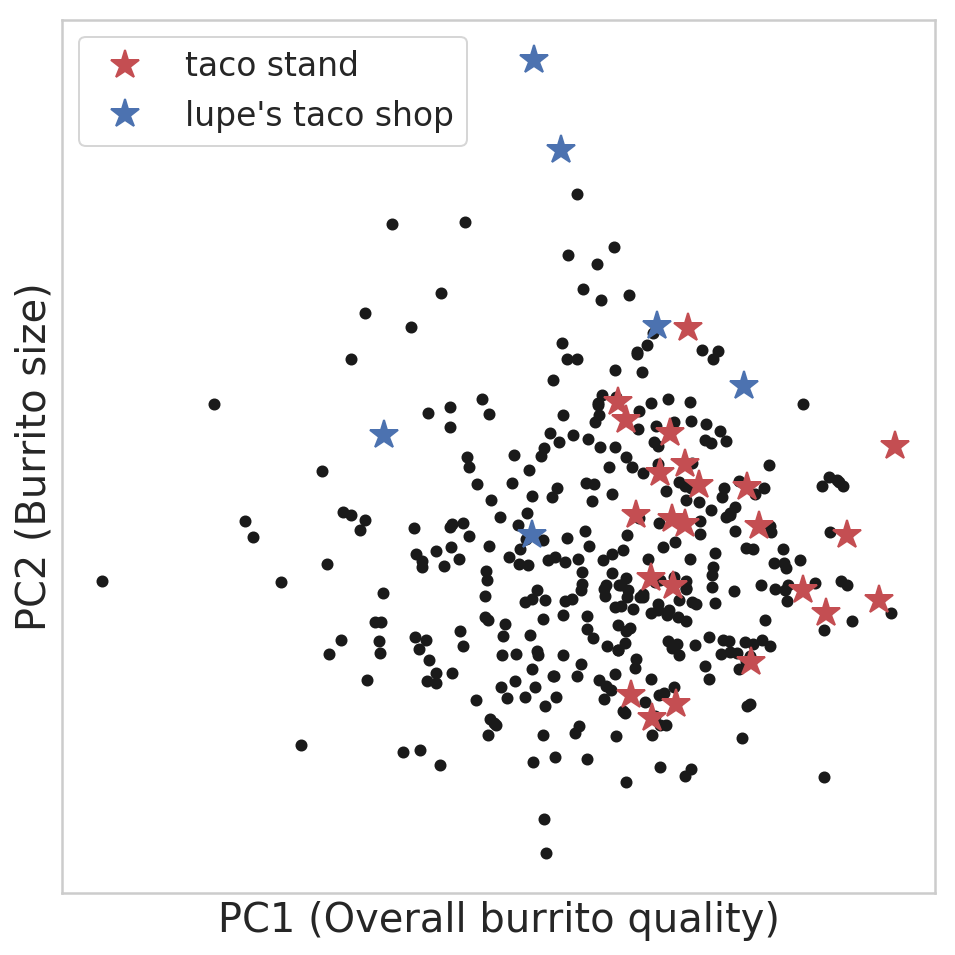

In [16]:
# Project data into PC space
dfpca_proj = np.dot(pca.components_,dfpca.T)

# Plot each burrito in PC space
plt.figure(figsize=(7,7))
plt.plot(-dfpca_proj[0],dfpca_proj[1],'k.',ms=10)
plt.xlabel('PC1 (Overall burrito quality)',size=20)
plt.ylabel('PC2 (Burrito size)', size=20)
plt.xticks([])
plt.yticks([])

# Plot some taco shops in separate colors
shops = ['taco stand',"lupe's taco shop"]
colors = ['r','b']
for i, s in enumerate(shops):
    burridx = np.argwhere(df.Location==s)
    plt.plot(-dfpca_proj[0][burridx],dfpca_proj[1][burridx],'*',color=colors[i],ms=15,label=s)
plt.legend()
plt.tight_layout()
plt.savefig('/gh/fig/cogshore/pca.png')

# 11. Inter-reviewer reliability

In [17]:
# Group ratings by location and burrito type
foi = ['Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity',
       'Salsa', 'Synergy', 'Wrap', 'overall']
cols_keep = np.append(foi, ['Location', 'Burrito', 'Reviewer', 'Date'])
df2 = df[cols_keep].dropna(axis=0).reset_index(drop=True)
burrito_groups = df2.groupby(['Location', 'Burrito']).groups

# For each burrito group, make pairs of ratings
burrito_pairs_idxs = []
for k, idxs in burrito_groups.items():

    # Only consider burrito groups with more than 1 rating
    if len(idxs) >= 2:
        
        # Only consider burrito groups with more than 1 distinct reviewer and date
        reviewer_array = df2.loc[idxs]['Reviewer'].values
        date_array = df2.loc[idxs]['Date'].values
        if len(np.unique(reviewer_array)) > 1 and len(np.unique(date_array)) > 1:
            
            # Make new pairs as long as possible
            pairing_reviewers = np.copy(reviewer_array)
            pairing_dates = np.copy(date_array)
            pairing_idxs = np.copy(idxs)
            can_make_pair = True
            while can_make_pair:
                
                # Cannot make pair if less than 2 unique dates, or 2 unique reviewers
                if len(np.unique(pairing_reviewers)) < 2 and len(np.unique(pairing_dates)) < 2:
                    can_make_pair = False

                else:
                    # Choose the first rating
                    rating1_i = pairing_idxs[0]
                    rating1_rev = pairing_reviewers[0]
                    rating1_date = pairing_dates[0]
                    
                    # Choose a rating that can go with this one
                    for i in range(1,len(pairing_idxs)):
                        rating2_i = pairing_idxs[i]
                        rating2_rev = pairing_reviewers[i]
                        rating2_date = pairing_dates[i]
                        
                        # If the pair of ratings is valid, then save the pair of rating indices
                        if (rating1_rev != rating2_rev) and (rating1_date != rating2_date):
                            burrito_pairs_idxs.append([rating1_i, rating2_i])
                            
                            # Remove the paired indices from the list of reviews to pair
                            pairing_reviewers = np.delete(pairing_reviewers, [0, i])
                            pairing_dates = np.delete(pairing_dates, [0, i])
                            pairing_idxs = np.delete(pairing_idxs, [0, i])
                            break

                        # Delete the first index if no pairings worked
                        if i == len(pairing_idxs)-1:
                            pairing_reviewers = np.delete(pairing_reviewers, 0)
                            pairing_dates = np.delete(pairing_dates, 0)
                            pairing_idxs = np.delete(pairing_idxs, 0)
                            

/Users/scott/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


N pairs = 49


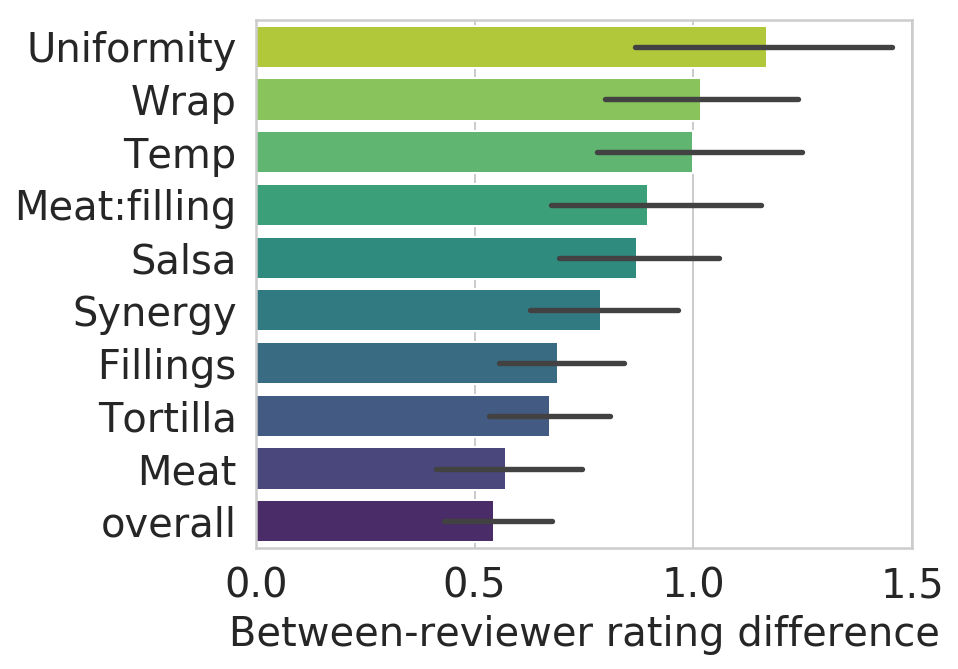

In [18]:
# Compute feature differences for each pair
df_feat = df2[foi]
N_pairs = len(burrito_pairs_idxs)
df_feat_diffs = pd.DataFrame()
for i in range(N_pairs):
    feature_diffs = np.abs(df_feat.loc[burrito_pairs_idxs[i][0]] - df_feat.loc[burrito_pairs_idxs[i][1]])
    df_feat_diffs = df_feat_diffs.append(feature_diffs, ignore_index=True)
    
# Plot average difference in order
df_plt = df_feat_diffs.stack().reset_index().drop('level_0', axis=1).rename(columns={'level_1':'feature', 0: 'diff'})
plt.figure(figsize=(7,5))
sns.barplot(y='feature', x='diff', data=df_plt, order=df_feat_diffs.mean().sort_values(ascending=False).index,
            palette='viridis_r')
plt.xlabel('Between-reviewer rating difference', size=20)
plt.ylabel('')
plt.xticks(np.arange(0,2,.5), size=20)
plt.yticks(size=20)
plt.xlim((0,1.5))
plt.tight_layout()
plt.savefig('/gh/fig/burritoposter/cogshore.png')

print('N pairs =', N_pairs)

In [19]:
# Simulate differences between random burrito pairings
np.random.seed(0)
N_sim = 1000 # Number of simulated burrito pairings

# Choose a random reviewer for each simulation
sim_rating1_options = np.hstack(burrito_pairs_idxs)
sim_rating1 = np.random.choice(sim_rating1_options, N_sim)
    
# Compute feature differences for random burritos
feat_diffs_null = defaultdict(list)
for i in range(N_sim):
    # Determine reviewer
    idx_rating1 = sim_rating1[i]
    rev1 = df2.loc[idx_rating1]['Reviewer']
    rest1 = df2.loc[idx_rating1]['Location']
    feats1 = df2.loc[idx_rating1].drop(['Location','Burrito','Reviewer','Date'])
    
    # Choose 2 valid random burritos from that reviewer
    got_2 = False
    while not got_2:
        # Choose another random burritos
        idx_rating2 = np.random.randint(len(df2))
        
        # Check if burritos are not from same restaurant
        rest2 = df2.loc[idx_rating2].Location
        rev2 = df2.loc[idx_rating2].Reviewer
        if (rest1 != rest2) and (rev1 != rev2):
            got_2 = True
            feats2 = df2.loc[idx_rating2].drop(['Location','Burrito','Reviewer','Date'])
            
    # Compute differences for each feature
    for k in feats1.keys():
        feat_diffs_null[k].append(np.abs(feats1[k] - feats2[k]))
df_feat_diff_null = pd.DataFrame(feat_diffs_null)

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.
/Users/scott/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


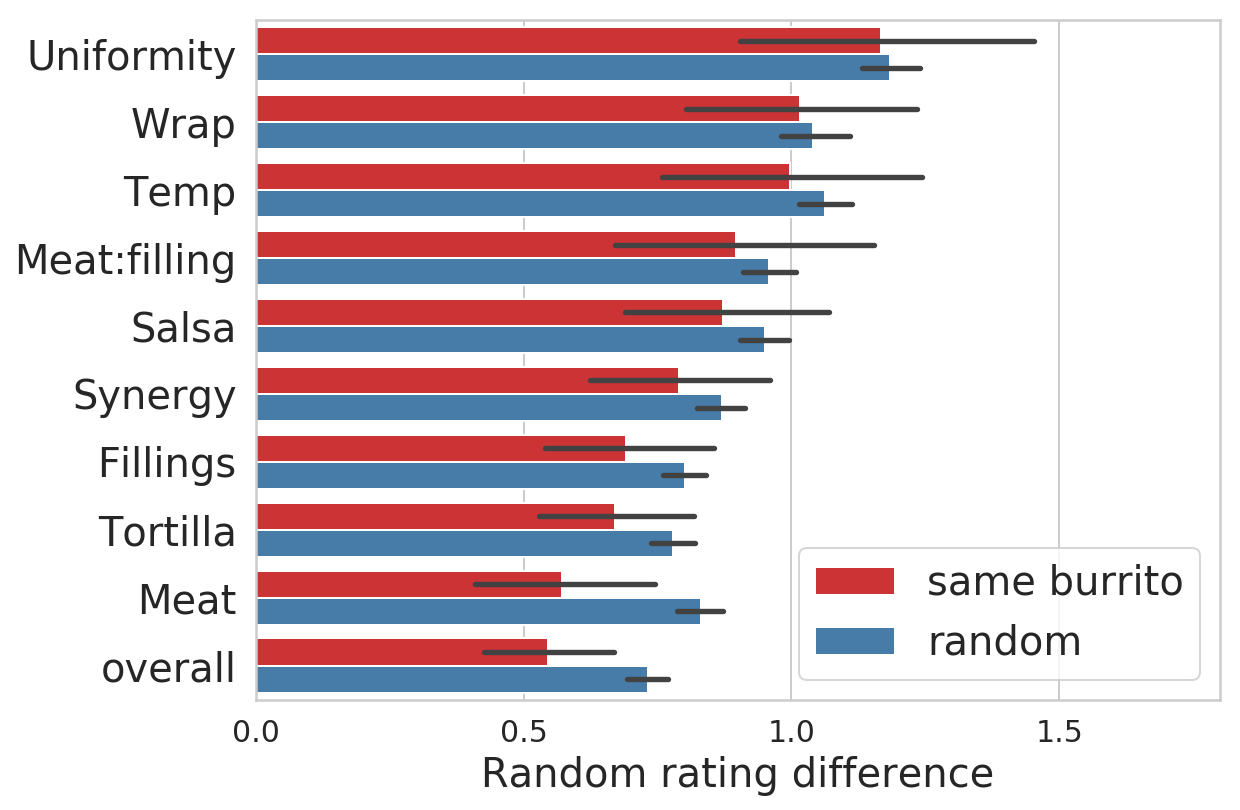

In [20]:
# Plot simulated and true paired rating differences together
df_feat_diffs['pairing'] = 'same burrito'
df_feat_diff_null['pairing'] = 'random'
df_plt = pd.concat([df_feat_diffs, df_feat_diff_null])

# Plot null average difference in order
df_plt = df_plt.set_index('pairing').stack().reset_index().rename(columns={'level_1':'feature', 0: 'diff'})
plt.figure(figsize=(9,6))
sns.barplot(y='feature', x='diff', hue='pairing', data=df_plt, palette='Set1',
            order=df_feat_diffs.mean().sort_values(ascending=False).index)
plt.xlabel('Random rating difference', size=20)
plt.ylabel('')
plt.legend(title='', fontsize=20)
plt.xticks(np.arange(0,2,.5), size=15)
plt.yticks(size=20)
plt.xlim((0,1.8))
plt.tight_layout()
plt.savefig('/gh/fig/cogshore/reliability_by_feature_compared.png')

In [21]:
# Print stats
print('Feature     p-value\n-------     -------')
ps = {}
for k in df_plt['feature'].unique():
    t, ps[k] = sp.stats.mannwhitneyu(df_feat_diffs[k].values,feat_diffs_null[k])
    print('{: <14}{:.3f}  '.format(k, ps[k]))
    

Feature     p-value
-------     -------
Fillings      0.121  
Meat          0.004  
Meat:filling  0.190  
Salsa         0.243  
Synergy       0.317  
Temp          0.285  
Tortilla      0.219  
Uniformity    0.358  
Wrap          0.292  
overall       0.042  


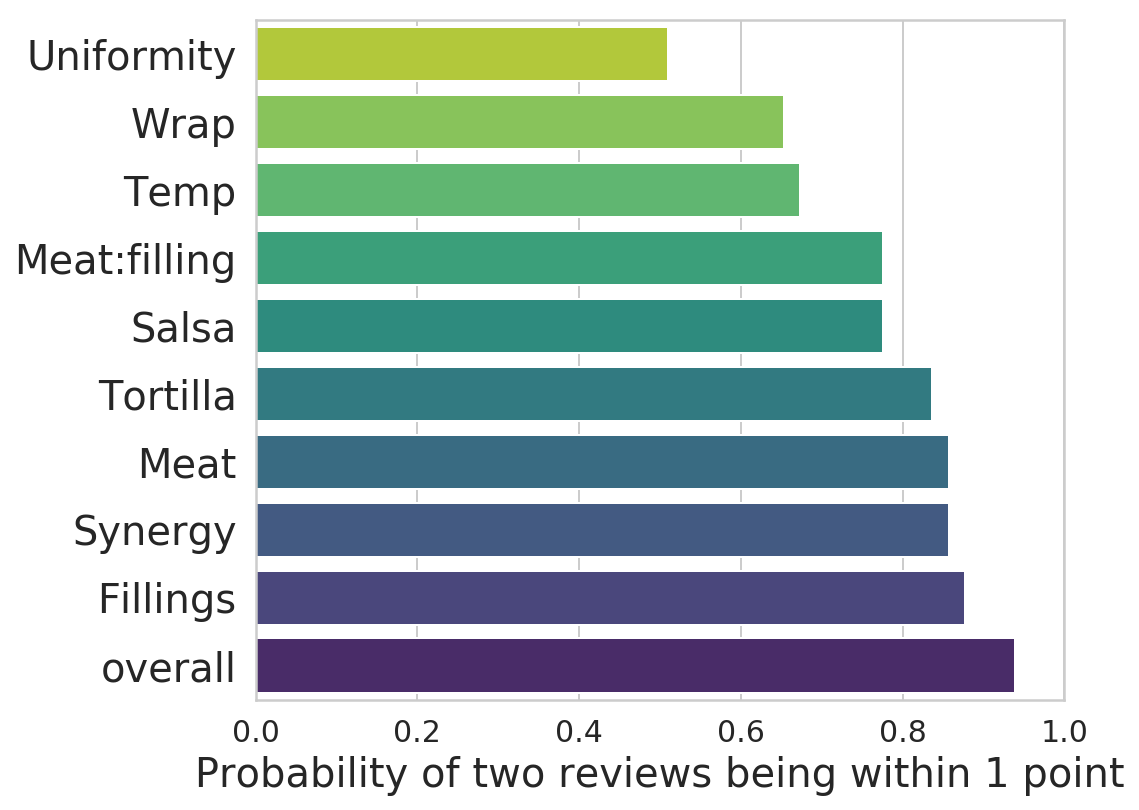

In [22]:
# Plot probability that the two ratings are within 1 point
dict_prob1 = {}
for k in df_plt['feature'].unique():
    dict_prob1[k] = [np.mean(df_feat_diffs[k].values <= 1)]
df_plt = pd.DataFrame(dict_prob1)
df_plt = pd.DataFrame(df_plt.stack()).reset_index().drop('level_0', axis=1).rename(columns={'level_1':'feature', 0:'prob_within'})

plt.figure(figsize=(8, 6))
sns.barplot(y='feature', x='prob_within', data=df_plt, palette='viridis_r',
            order=df_plt.sort_values('prob_within')['feature'])
plt.ylabel('')
plt.xlabel('Probability of two reviews being within 1 point', size=20)
plt.xticks(np.arange(0,1.1,.2), size=15)
plt.yticks(size=20)
plt.tight_layout()
plt.savefig('/gh/fig/cogshore/reliability_within1.png')